# Prep images for convulational nueral network

In [1]:
"""
Loads CSV data, loads the list of images found in the CSV as local files in an Images folder,
and prepares and serializes the data to be used in a mixed data MLP/CNN model.
"""

# Standard imports for this process
import pandas as pd
from pathlib import Path
import numpy as np
import requests
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# load the balanced and cleaned CSV file 
# Read in the CSV file
cleaner_df = pd.read_csv(Path("Resources/Clean_n_Balanced.csv"))
cleaner_df.head()

,Image Index,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000003_000.png,81,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,00000003_001.png,74,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,00000003_002.png,75,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,00000003_003.png,76,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,00000003_004.png,77,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [3]:
# Define the location of the Image files (could be a URL or local folder Path)
base_img_loc = "./Images/"
is_local = True

# Create an empty list for image processing
imgs_list = []

# Loop through the DataFrame and build and append the full image locations
for i in range(len(cleaner_df)):
    img_idx = cleaner_df.iloc[i,0]
    imgs_list.append(base_img_loc + img_idx)

# Display a few to verify correct location (Path in this case)
imgs_list[0:5]

['./Images/00000003_000.png',
 './Images/00000003_001.png',
 './Images/00000003_002.png',
 './Images/00000003_003.png',
 './Images/00000003_004.png']

.0
...........................................................................75
...........................................................................150
...........................................................................225
...........................................................................300
...........................................................................375
...........................................................................450
...........................................................................525
...........................................................................600
...........................................................................675
...........................................................................750
...........................................................................825
...........................................................................900
..................................................

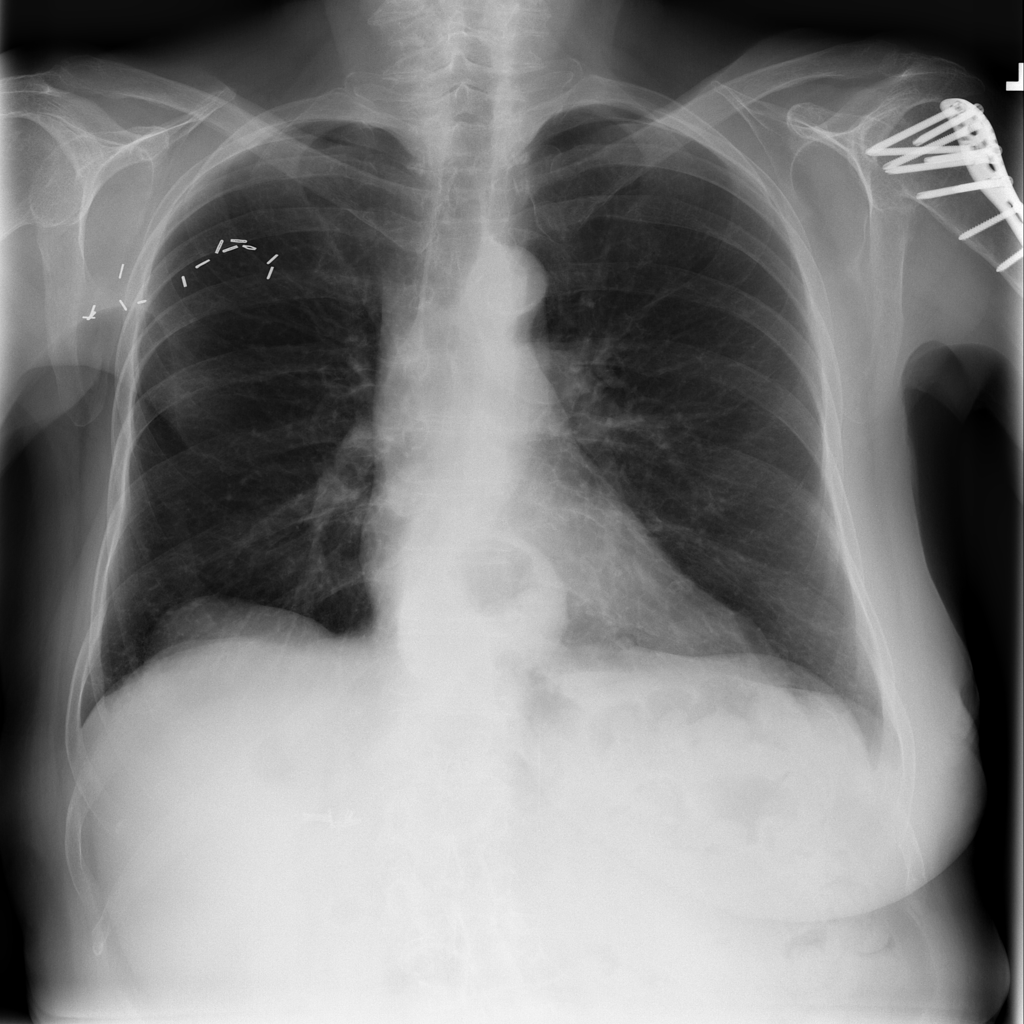

In [4]:
# Create and empty list to pack images together
imgs = []

# Loop through the images list to open and append each images raw data
for i, img in enumerate(imgs_list):
    # As this is roughly three thousand images, show progress only with a '.' & new line at 75 characers
    if i % 75 == 0:
        print(f".{i}")
    else:
        print(".", end="")

    # Stream the raw image data from the specified location
    if is_local:
        # Just open and append the image to the packed list
        imgs.append(Image.open(img))
    else:
        # Load the URL as a raw stream and append
        response = requests.get(img, stream=True).raw
        imgs.append(Image.open(response))

# View the first image to confirm process
imgs[0]

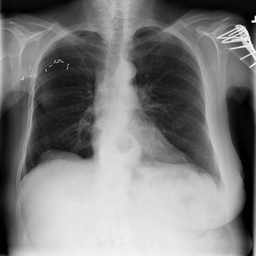

In [5]:
# Resize the images to a more managable size for the CNN
target_size = (256, 256)
resized_imgs = [img.resize(target_size, resample = Image.LANCZOS) for img in imgs]

# And verify with a view
resized_imgs[0]

### Onto the Numbers

At this point will move from human eyes visual data to numbers for computer "vision"

In [6]:
# Convert all images to floating point numpy arrays
#   This will take the pixel value of grayscale images from 0 (black) to 255 (white)
float_images = [np.array(img).astype(np.float32) for img in resized_imgs]

# Normalize the pixel brightness to numbers between 0 and 1
normalized_images = [img/255 for img in float_images]

# Verify we now have numbers between 0 and 1 (by looking at first image)
print(normalized_images[0])

[[0.21176471 0.11372549 0.06666667 ... 0.05098039 0.05882353 0.04313726]
 [0.20392157 0.10980392 0.06666667 ... 0.05098039 0.05882353 0.04313726]
 [0.20392157 0.10588235 0.0627451  ... 0.05098039 0.05882353 0.04705882]
 ...
 [0.04313726 0.03921569 0.03529412 ... 0.39215687 0.6901961  0.7764706 ]
 [0.09803922 0.09411765 0.08627451 ... 0.4        0.7058824  0.7882353 ]
 [0.1882353  0.18431373 0.17254902 ... 0.4117647  0.72156864 0.8       ]]


### Finalize data prep

The intent here would be to create a mixed data model with a CNN for the images and a multi layered model to include the patient's age and gender as well as the direction the X-ray was taken.  *This intent may not be fulfilled as time contraint.*

In [7]:
# Define X Numeric + Categorical (cat) data and Y as a Matrix
X = cleaner_df[["Patient Age", "Patient Gender", "View Position"]].copy()
Y = cleaner_df.copy()
Y = Y.drop(labels=["Image Index", "Patient Age", "Patient Gender", "View Position"], axis=1)

# Double check we got what we want
print(f"X Shape: {X.shape}")
print(X.head())
print(f"Y Shape: {Y.shape}")
print(Y.head())


X Shape: (3343, 3)
   Patient Age  Patient Gender  View Position
0           81               0              1
1           74               0              1
2           75               0              1
3           76               0              1
4           77               0              1
Y Shape: (3343, 15)
   Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
0            0             0              0      0         0          0   
1            0             0              0      0         0          0   
2            0             0              0      0         0          0   
3            0             0              0      0         0          0   
4            0             0              0      0         0          0   

   Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0         0       1             0     0           0       0   
1         0       1             0     0           0       0   
2         0       1             0     0      

In [8]:
# Split the data to fit the scale to the training set.
X_cat_train, X_cat_test, X_img_train, X_img_test, Y_train, Y_test = train_test_split(X, normalized_images, Y, random_state=1)

# Double check split via shapes or lengths
print(f"X Cat Train Shape: {X_cat_train.shape}")
print(f"X Cat Test Shape: {X_cat_test.shape}")
print(f"X Img Train Shape: {len(X_img_train)}")
print(f"X Img Test Shape: {len(X_img_test)}")
print(f"Y Train Shape: {Y_train.shape}")
print(f"Y Test Shape: {Y_test.shape}")

X Cat Train Shape: (2507, 3)
X Cat Test Shape: (836, 3)
X Img Train Shape: 2507
X Img Test Shape: 836
Y Train Shape: (2507, 15)
Y Test Shape: (836, 15)


In [9]:
# Scale the X Cat Train and Test data
scaler = StandardScaler()

# Fit the scaler to the features training dataset
scaler.fit(X_cat_train)

## And scale the training and testing?
X_cat_train_scaled = scaler.transform(X_cat_train)
X_cat_test_scaled = scaler.transform(X_cat_test)

# Preview the scaled data
X_cat_train_scaled[:5]

array([[ 0.94207736, -1.16456129, -1.11014106],
       [-0.51855738,  0.85869246, -1.11014106],
       [ 1.05892814, -1.16456129, -1.11014106],
       [-0.28485582, -1.16456129, -1.11014106],
       [-0.9275351 ,  0.85869246, -1.11014106]])

### Serialize the data

This concludes the preprocessing that I feel should be. This also concludes my ability to process on my own very old laptop. Will pickle the Python data to be more suitable for uploading to Google and continuing to model with Google Colab.

In [10]:
# Create data list for dumping
data_dump = [X_cat_train_scaled, X_cat_test_scaled, X_img_train, X_img_test, Y_train, Y_test]

# Open a file with with to auto close and with write permission
with open('./Resources/Packed_Data.pkl', 'wb') as file:
    # Dump the data into the pickle file
    pickle.dump(data_dump, file)